Задачи на основе инстанс-сегментации, которая приведена в файле "Mask R-CNN instance segmentation on custom dataset"

#6 minut

In [ ]:
# Начнем с загрузки необходимых наборов данных, установки необходимых пакетов и их импорта.
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar

In [ ]:
%pip install -qU torch_snippets==0.5 # вспомогательная библиотека для удобной работы с PyTorch (содержит полезные функции для загрузки данных, визуализации и т. д.).
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
%pip install -q -U 'git+https://github.com/sizhky/cocoapi.git@patch-1#subdirectory=PythonAPI' # Этот пакет нужен для работы с форматом аннотаций COCO (который используется в ADE20K).

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 30.4 MB/s eta 0:00:00
   ━━━━

In [ ]:
from torch_snippets import *
from torch_snippets.inspector import inspect # Инструмент для отладки (показывает структуру данных).
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # Класс для замены головы модели Faster R-CNN.
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor # Класс для замены головы модели Mask R-CNN.

from engine import train_one_epoch, evaluate # готовые циклы обучения/валидации из engine.py
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# пути к изображениям и аннотациям из ADE20K с помощью Glob из torch_snippets
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

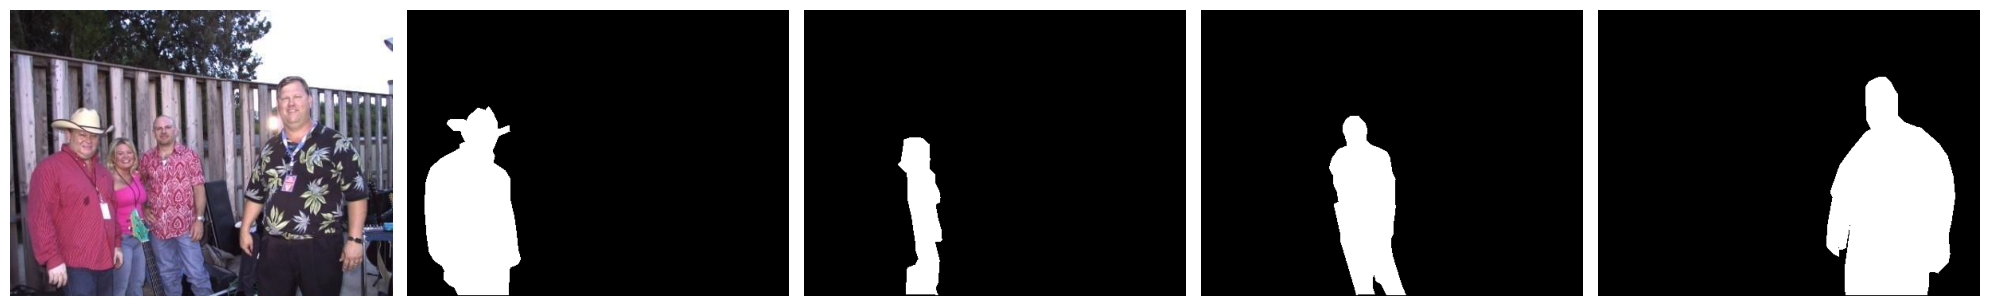

In [ ]:
f = 'ADE_train_00014301'

im = read(find(f, all_images), 1) # поиск и чтение изображения
an = read(find(f, all_annots), 1).transpose(2,0,1) # поиск и чтение аннотации
r,g,b = an # Семантические классы в красном канале, номера инстансов в зелёном канале, синий не используется
nzs = np.nonzero(r==4) # Выбор класса "person" (4), на выходе массив индектов
instances = np.unique(g[nzs]) # извлечение масок инстансов.
masks = np.zeros((len(instances), *r.shape)) # формируем массив масок по количеству инстансов
for ix,_id in enumerate(instances):
    masks[ix] = g==_id # # Маска для инстанса _id, коротко говоря формируем каждую маску

subplots([im, *masks], sz=20) # Вывод изображения и масок, где sz=20 — параметр, задающий размер области отображения (например, в дюймах или пикселях).



In [ ]:
# ради интереса посмотрим на кусок от r, что из себя представляет
r[:200, :200] # как можно заметить пиксели обозначены цифрами классов (нажмите на show data)

In [ ]:
instances # 4 человека и соотвественно столько же индексов

array([1, 2, 3, 4], dtype=uint8)

In [ ]:
# Пробегаем по аннотациям и фильтруем аннотации, оставляя только те, которые содержат объекты класса "person" (класс 4 в ADE20K)
annots = []
for ann in Tqdm(all_annots[:5000]):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|██████████| 5000/5000 [00:32<00:00, 152.85it/s]


In [ ]:
from sklearn.model_selection import train_test_split # разбиваем
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [ ]:
def get_transform(train): # трансформации
    image_transforms = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

In [ ]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N): # items-список id изображений, N-количество элементов в датасете
        self.items = items
        self.transforms = transforms
        self.N = N

    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1) # загрузка маски (предположительно в формате HWC → CHW)
        r,g,b = an # разделение на каналы (R, G, B) и далее получаем маски класса "person"
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks

    def __getitem__(self, ix): # получение элемента по индексу
        _id = self.items[ix] # получаем ID изображения
        img_path = f'images/training/{_id}.jpg' # соответственно изображение
        mask_path = f'annotations_instance/training/{_id}.png' # маска
        masks = self.get_mask(mask_path) # получаем маски
        obj_ids = np.arange(1, len(masks)+1) # список id объектов
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)

        # Обработка bounding boxes (ограничивающих рамок):
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i]) # координаты пикселей объекта
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):  # Если bbox слишком мал, расширяем его до 10x10
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32) # преобразуем в тензор

        # Подготовка target (целевых данных для модели)
        labels = torch.ones((num_objs,), dtype=torch.int64) # все объекты принадлежащие одному классу
        masks = torch.as_tensor(masks, dtype=torch.uint8) # маски в тензорном формате
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # площадь bbox
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64) # флаг "группа объектов" (0)
        image_id = torch.tensor([ix]) # ID изображения

        target = {} # словарь, ниже его заполняем
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
          img = img/255.
        return img, target

    def __len__(self):
        return self.N

    def choose(self):
        return self[randint(len(self))]

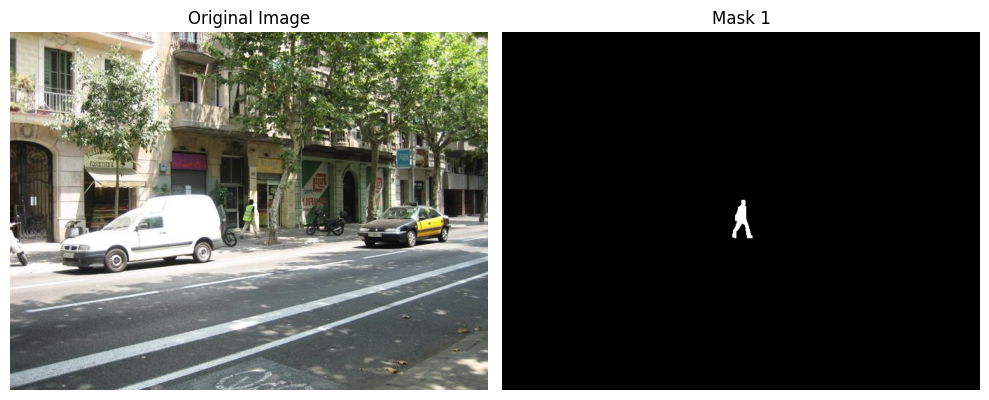

In [ ]:
x = MasksDataset(trn_items, get_transform(train=True), N=100) # инициализация класса с передачей trn_items (списка идентификаторов изображений )
im,targ = x[0] # Получение конкретного примера, где im-тензор изображения, а targ-словарь с целевыми данными для обучения модели

# inspect(im,targ)
# subplots([im, *targ['masks']], sz=10)

# Функция для правильной визуализации
def visualize_sample(image, target):
    # Преобразуем изображение
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Меняем порядок каналов
        if image.max() <= 1.0:  # Если нормализовано [0,1]
            image = (image * 255).astype(np.uint8)

    # Преобразуем маски
    masks = []
    for mask in target['masks']:
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()
        masks.append(mask)

    # Создаем фигуру
    n_subplots = 1 + len(masks)
    fig, axes = plt.subplots(1, n_subplots, figsize=(5*n_subplots, 5))

    # Если только 1 subplot, axes будет не списком
    if n_subplots == 1:
        axes = [axes]

    # Отображаем оригинальное изображение
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Отображаем маски
    for i, mask in enumerate(masks, 1):
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(f'Mask {i}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Визуализируем
visualize_sample(im, targ)

In [ ]:
# Создает Mask R-CNN с измененными головами под наши классы
def get_model_instance_segmentation(num_classes):
    # загрузить предварительно обученную модель сегментации экземпляра на COCO
    # Загружается модель Mask R-CNN с backbone ResNet-50 и FPN (Feature Pyramid Network), FPN помогает работать с объектами разных масштабов
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # получить количество входных признаков для классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Замена головы для классификации объектов (bbox)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # теперь получите количество входных признаков для классификатора маски
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256 # для более простых задач можно уменьшить
    # Замена головы для сегментации (маски)
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [ ]:
model = get_model_instance_segmentation(2).to(device) # 2 = класс "person" + фон
model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 185MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=len(trn_items))
dataset_test = MasksDataset(val_items, get_transform(train=False), N=len(val_items))

# загрузчики
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [ ]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad] # Собирает только те параметры модели, которые требуют градиенты (для обучения)
optimizer = torch.optim.SGD(params,
                            lr=0.005, # Скорость обучения, стандартная начальная скорость обучения для Mask R-CNN
                            momentum=0.9, # Инерция обновления, помогает быстрее сходиться и избегать локальных минимумов
                            weight_decay=0.0005) # L2-регуляризация, предотвращает переобучение через L2-регуляризацию

# Настройка планировщика скорости обучения
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, # StepLR - уменьшает скорость обучения в заданные моменты
                                                step_size=3, # каждые 3 эпохи будет срабатывать
                                                gamma=0.1) # новое LR = текущее LR * 0.1 (резкое уменьшение)

In [ ]:
# The following code is for illustration purpose only
model.eval() # Переводит модель в режим оценки (inference)
pred = model(dataset[0][0][None].to(device)) # берёт первый элемент датасета, извлекает только изображение (без аннотаций), [None] - добавляет размерность батча (меняет форму с [C,H,W] на [1,C,H,W])
inspect(pred[0]) # Функция inspect (из torch_snippets) покажет структуру словаря предсказания, который содержит:
#
# {
#     'boxes':  torch.Tensor  # [N,4] - координаты bbox (x1,y1,x2,y2)
#     'labels': torch.Tensor  # [N] - классы объектов
#     'scores': torch.Tensor  # [N] - уверенность модели (0-1)
#     'masks':  torch.Tensor  # [N,1,H,W] - бинарные маски объектов
# }

══════════════════════════════════════════════════════════════════

dict of 4 items

tensor([[100.6325, 278.8434, 181.1074, 311.0153],
        [436.4055, 291.8052, 594.0551, 347.8624],
        [241.2256, 270.0959, 261.6641, 294.8120],
        [ 98.3090, 254.4693, 258.7141, 303.2531],
        [208.3494, 257.2820, 222.2775, 285.5317],
        [339.5547, 284.0796, 363.5199, 299.6605],
        [360.3684, 285.1225, 376.4934, 310.9322],
        [208.4638, 273.2220, 233.2649, 293.3954],
        [218.3583, 340.6445, 683.0000, 512.0000],
        [201.6766, 256.2021, 231.2002, 291.1892],
        [234.8834, 248.2902, 251.4877, 288.9262],
        [676.4607, 273.0497, 683.0000, 336.2036],
        [377.2166, 400.2326, 683.0000, 505.1627],
        [225.0601, 245.0388, 242.6394, 278.0594],
        [107.8328, 403.1744, 464.1711, 499.8211],
        [201.6776, 254.6983, 223.6901, 277.9533],
        [502.6864, 266.6878, 613.3142, 354.6480],
        [495.1760, 450.5742, 670.7936, 508.0876],
        [223.9559, 238.6710, 255.7674, 289.9527],
        [210.9284, 262.7274, 238.7493, 289.6938],
        [203.5307, 256.2561, 214.3158, 276.1439],
        [241.0173, 250.0130, 256.0639, 293.7654],
        [105.3285, 240.7627, 117.1221, 249.2601],
        [213.5920, 375.6703, 509.3027, 484.8413],
        [443.8779, 281.8142, 679.6671, 354.5518],
        [361.1187, 274.3100, 383.3743, 310.6201],
        [233.9559, 253.4101, 266.0934, 295.0799],
        [253.9484, 474.6552, 396.0197, 512.0000],
        [ 87.6551, 163.3414, 106.7922, 191.8532],
        [205.2303, 261.5965, 219.1860, 292.8665],
        [429.4055,  90.1364, 550.7448, 321.6345],
        [231.5009, 255.0147, 245.3016, 288.4960],
        [207.6709, 237.0240, 241.9205, 287.5864],
        [231.4167, 241.2978, 248.1333, 270.4160],
        [354.1984, 271.9949, 362.7202, 287.3860],
        [  8.8045,  49.1176,  59.5134, 217.1802],
        [128.0107, 345.9548, 451.1367, 480.8764],
        [583.1849, 287.7575, 683.0000, 338.7079],
        [512.2810,  71.2788, 578.1332, 200.7804],
        [274.5675, 219.6068, 302.4170, 280.0743],
        [366.7197, 254.9930, 381.3632, 300.4874],
        [328.4918, 285.1413, 358.8507, 298.5798],
        [111.9593, 241.7637, 190.9624, 315.8075],
        [530.3261,  40.0168, 594.0283, 182.4608],
        [351.4487, 268.3857, 360.0524, 288.5670],
        [101.5597, 294.0772, 488.8738, 385.9899],
        [525.0413,  29.2080, 681.6663, 375.5448],
        [304.2336, 312.2167, 677.2880, 397.7255],
        [195.2236, 242.2836, 206.0618, 268.7047],
        [228.8640, 239.2728, 240.4150, 260.7991],
        [674.0134, 270.0760, 682.8707, 288.4985],
        [232.2522, 245.6583, 256.6016, 276.9982],
        [178.1007, 436.1218, 482.3005, 512.0000],
        [102.1644, 241.1713, 112.1864, 250.2015],
        [422.0016, 151.3350, 630.8101, 355.7517],
        [338.4521, 273.3289, 361.7527, 290.4552],
        [499.3185, 113.9600, 609.5792, 176.2175],
        [458.2129, 244.2200, 589.2641, 335.8212],
        [422.5413, 102.7863, 456.3789, 135.7835],
        [227.5061, 243.3488, 239.0374, 269.8770],
        [462.5620, 198.3428, 587.0547, 397.5534],
        [124.2655, 253.6734, 134.9280, 264.4853],
        [475.8501, 102.3974, 582.0848, 312.6517],
        [323.4814, 249.9868, 331.7592, 282.5116],
        [209.1631, 262.3998, 235.5139, 278.3251],
        [334.2514, 250.7097, 345.6319, 276.8813],
        [656.3290,  79.6174, 677.2832, 102.9394],
        [374.5327, 265.3577, 384.8930, 298.8391],
        [ 69.2751, 271.1066, 129.2102, 306.1874],
        [658.9315,  51.9346, 681.7536, 107.3790],
        [637.4286, 179.3204, 681.8342, 310.6772],
        [ 99.8653,  56.9075, 652.4506, 464.6062],
        [405.5114, 168.7855, 453.5446, 196.8830],
        [654.7928,  77.1527, 683.0000, 113.7386],
        [485.2026, 128.9914, 518.1395, 194.3464],
        [335.0109, 271.0966, 368.2213, 305.0926],
        [333.5135, 274.1164, 356.6732, 298.7122],
        [130.0470, 256.1432, 136.3153, 264.4068],
        [123.6237, 191.6369, 422.7833, 436.7445],
        [468.8406, 100.9196, 530.7816, 202.9490],


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1], device='cuda:0')

tensor([0.7742, 0.7583, 0.7344, 0.7172, 0.7171, 0.6864, 0.6802, 0.6783, 0.6775,
        0.6756, 0.6748, 0.6741, 0.6716, 0.6698, 0.6689, 0.6649, 0.6646, 0.6545,
        0.6492, 0.6470, 0.6451, 0.6447, 0.6407, 0.6377, 0.6363, 0.6335, 0.6329,
        0.6280, 0.6267, 0.6257, 0.6253, 0.6219, 0.6161, 0.6104, 0.6098, 0.6065,
        0.6049, 0.6043, 0.6026, 0.6026, 0.5994, 0.5948, 0.5938, 0.5930, 0.5905,
        0.5904, 0.5885, 0.5884, 0.5874, 0.5854, 0.5839, 0.5835, 0.5830, 0.5813,
        0.5803, 0.5795, 0.5756, 0.5748, 0.5710, 0.5704, 0.5700, 0.5696, 0.5694,
        0.5689, 0.5685, 0.5684, 0.5672, 0.5659, 0.5630, 0.5628, 0.5603, 0.5575,
        0.5550, 0.5545, 0.5545, 0.5531, 0.5531, 0.5529, 0.5525, 0.5521, 0.5520,
        0.5519, 0.5519, 0.5512, 0.5500, 0.5492, 0.5485, 0.5474, 0.5471, 0.5460,
        0.5451, 0.5450, 0.5444, 0.5440, 0.5438, 0.5430, 0.5429, 0.5423, 0.5415,
        0.5404], device='cuda:0', grad_fn=<IndexBackward0>)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
       grad_fn=<UnsqueezeBackward0>)

══════════════════════════════════════════════════════════════════

In [ ]:
# The following code is for illustration purpose only
pred[0]['masks'].shape
# torch.Size([100, 1, 536, 559])

torch.Size([100, 1, 512, 683])

#30 minut

In [ ]:
# Обучение модели
# Данный код выполняет тонкую настройку (fine-tuning) предобученной модели Mask R-CNN
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/469]  eta: 0:10:09  lr: 0.000016  loss: 6.0862 (6.0862)  loss_classifier: 0.6901 (0.6901)  loss_box_reg: 0.2725 (0.2725)  loss_mask: 5.1181 (5.1181)  loss_objectness: 0.0040 (0.0040)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 1.2990  data: 0.0383  max mem: 4142
Epoch: [0]  [ 10/469]  eta: 0:04:53  lr: 0.000122  loss: 4.6923 (4.6323)  loss_classifier: 0.6614 (0.6196)  loss_box_reg: 0.3064 (0.2815)  loss_mask: 3.6260 (3.7018)  loss_objectness: 0.0175 (0.0189)  loss_rpn_box_reg: 0.0077 (0.0104)  time: 0.6394  data: 0.0371  max mem: 4142
Epoch: [0]  [ 20/469]  eta: 0:04:48  lr: 0.000229  loss: 2.3557 (3.2260)  loss_classifier: 0.4906 (0.5000)  loss_box_reg: 0.3064 (0.3292)  loss_mask: 1.1165 (2.3500)  loss_objectness: 0.0265 (0.0313)  loss_rpn_box_reg: 0.0123 (0.0156)  time: 0.6091  data: 0.0629  max mem: 4142
Epoch: [0]  [ 30/469]  eta: 0:04:43  lr: 0.000336  loss: 1.3273 (2.5066)  loss_classifier: 0.2875 (0.4072)  loss_box_reg: 0.2571 (0.3075)  loss_mask: 0.5999 (1.7446) 

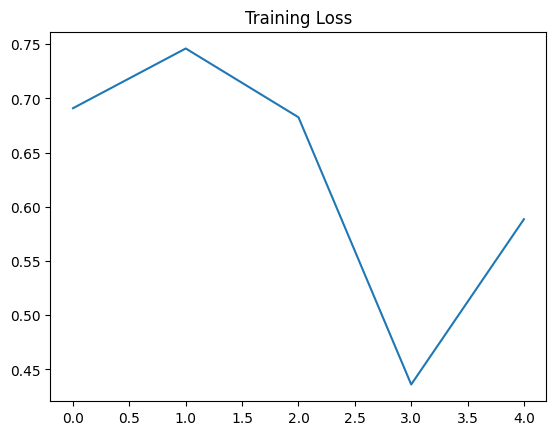

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

tensor([[[0.4039, 0.4510, 0.5255,  ..., 0.2588, 0.2196, 0.2667],
         [0.4196, 0.4039, 0.4431,  ..., 0.2392, 0.2196, 0.2392],
         [0.4118, 0.3922, 0.4235,  ..., 0.2431, 0.2431, 0.2431],
         ...,
         [0.1529, 0.1686, 0.1843,  ..., 0.1804, 0.1804, 0.1804],
         [0.2471, 0.2588, 0.2706,  ..., 0.1804, 0.1804, 0.1804],
         [0.3020, 0.3137, 0.3176,  ..., 0.1804, 0.1804, 0.1804]],

        [[0.4275, 0.4706, 0.5373,  ..., 0.1255, 0.0863, 0.1333],
         [0.4431, 0.4235, 0.4549,  ..., 0.1137, 0.0941, 0.1137],
         [0.4392, 0.4118, 0.4353,  ..., 0.1255, 0.1255, 0.1255],
         ...,
         [0.2275, 0.2431, 0.2588,  ..., 0.2431, 0.2431, 0.2431],
         [0.3137, 0.3255, 0.3373,  ..., 0.2431, 0.2431, 0.2431],
         [0.3686, 0.3804, 0.3843,  ..., 0.2431, 0.2431, 0.2431]],

        [[0.2784, 0.3529, 0.5020,  ..., 0.0275, 0.0000, 0.0353],
         [0.2941, 0.3059, 0.4118,  ..., 0.0157, 0.0000, 0.0157],
         [0.2784, 0.2941, 0.3922,  ..., 0.0235, 0.0235, 0.

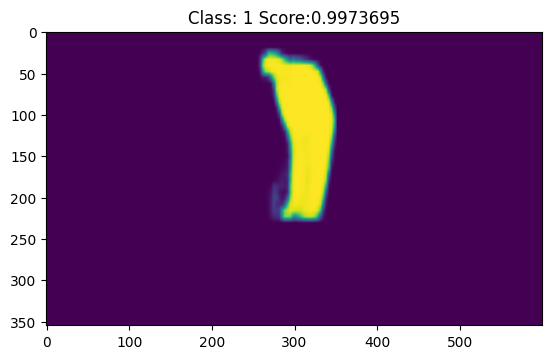

In [ ]:
# Инференс обученной модели Mask R-CNN на тестовом изображении,
# визуализация исходного изображения и предсказанных масок объектов с указанием их классов и уверенности модели.
model.eval()
im = dataset_test[7][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks']\
                      [i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels']\
                   [i].cpu().numpy())+' Score:'+str(\
                  prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

# Задача 1

Модифицируйте код вывода масок, чтобы отображались только объекты с confidence score > 0.7. Добавьте визуализацию bounding boxes прямо на исходном изображении с разными цветами для разных классов.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


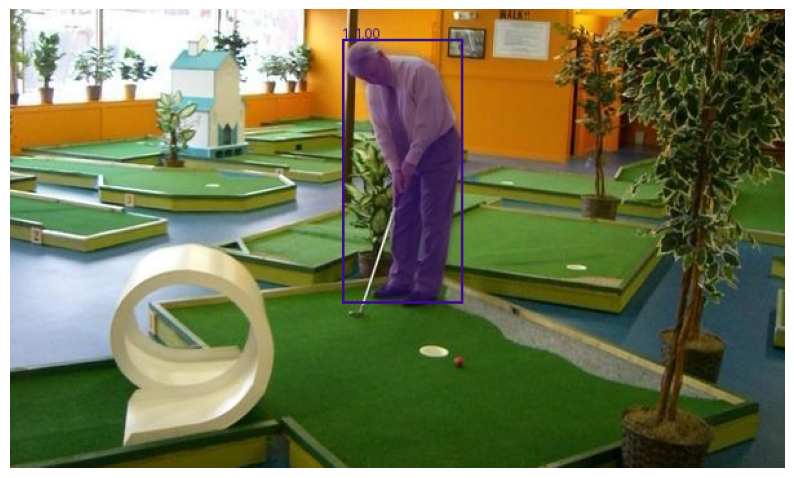

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as F
from PIL import Image, ImageDraw, ImageFont

# Переводим изображение в PIL формат для удобства рисования
im_tensor = dataset_test[7][0]
im = F.to_pil_image(im_tensor.cpu())
draw = ImageDraw.Draw(im)

# Модель в режиме оценки
model.eval()

# Генерация разных цветов для классов
random.seed(42)
colors = {}
for i in range(1, 91):  # если COCO — до 90 классов
    colors[i] = tuple(random.randint(0, 255) for _ in range(3))

with torch.no_grad():
    prediction = model([im_tensor.to(device)])

# Достаём данные предсказаний
pred = prediction[0]
boxes = pred['boxes'].cpu()
labels = pred['labels'].cpu()
scores = pred['scores'].cpu()
masks = pred['masks'].cpu()

# Устанавливаем порог уверенности
threshold = 0.7

# Рисуем маски и прямоугольники на копии изображения
for i in range(len(scores)):
    if scores[i] < threshold:
        continue

    box = boxes[i].numpy().astype(int)
    label = labels[i].item()
    score = scores[i].item()
    mask = masks[i, 0].numpy()

    color = colors[label]

    # Применяем маску поверх изображения
    mask_img = Image.fromarray((mask * 128).astype(np.uint8)).convert("L")
    color_mask = Image.new("RGB", im.size, color)
    im.paste(color_mask, mask=mask_img)

    # Нарисовать прямоугольник и текст
    draw.rectangle(box.tolist(), outline=color, width=2)
    draw.text((box[0], box[1] - 10), f"{label}: {score:.2f}", fill=color)

# Показать итоговое изображение
plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.axis("off")
plt.show()


## Задача 2

Добавьте текстовый отчет после обработки, который подсчитывает количество обнаруженных объектов каждого класса и выводит среднюю уверенность по классам.

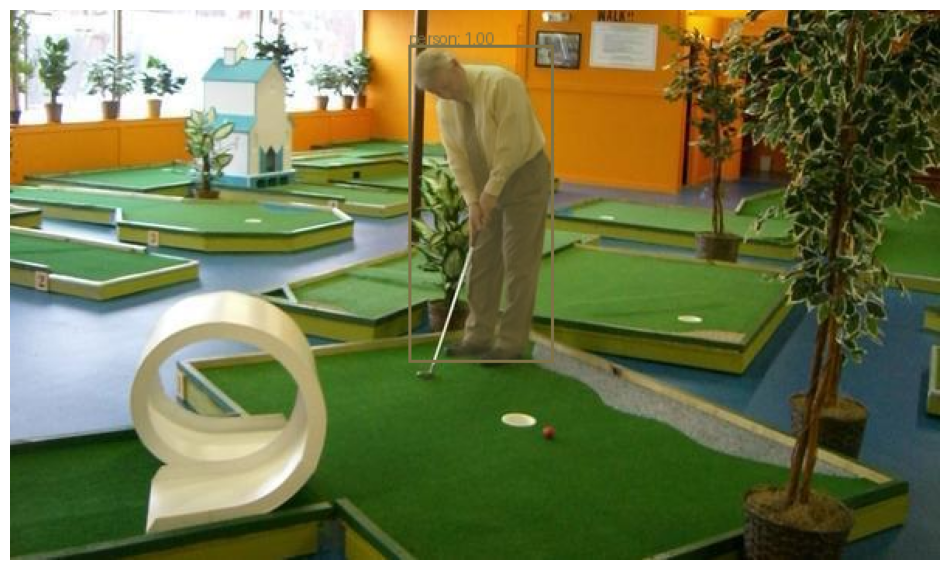

=== Отчет об обнаруженных объектах ===

person: 1 объект(ов), средняя уверенность: 1.00

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image, ImageDraw
import torchvision.transforms.functional as F
from collections import defaultdict

# Названия классов COCO
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Получаем изображение
im_tensor = dataset_test[7][0]
im = F.to_pil_image(im_tensor.cpu())
draw = ImageDraw.Draw(im)

model.eval()
threshold = 0.7

# Генерация цветов для классов
random.seed(42)
colors = {i: tuple(random.randint(0, 255) for _ in range(3)) for i in range(len(COCO_INSTANCE_CATEGORY_NAMES))}

# Словари для подсчёта
class_counts = defaultdict(int)
class_confidences = defaultdict(list)

with torch.no_grad():
    prediction = model([im_tensor.to(device)])

pred = prediction[0]
boxes = pred['boxes'].cpu()
labels = pred['labels'].cpu()
scores = pred['scores'].cpu()
masks = pred['masks'].cpu()

for i in range(len(scores)):
    score = scores[i].item()
    if score < threshold:
        continue

    label = labels[i].item()
    box = boxes[i].numpy().astype(int)
    mask = masks[i, 0].numpy()
    class_name = COCO_INSTANCE_CATEGORY_NAMES[label]
    color = colors[label]

    # Подсчёты для отчета
    class_counts[class_name] += 1
    class_confidences[class_name].append(score)

    # Отображение маски
    mask_img = Image.fromarray((mask * 128).astype(np.uint8)).convert("L")
    color_mask = Image.new("RGB", im.size, color)
    im.paste(color_mask, mask=mask_img)

    # Bounding box и текст
    draw.rectangle(box.tolist(), outline=color, width=2)
    draw.text((box[0], box[1] - 10), f"{class_name}: {score:.2f}", fill=color)

# Показ результата
plt.figure(figsize=(12, 12))
plt.imshow(im)
plt.axis("off")
plt.show()

# Текстовый отчёт
print("=== Отчет об обнаруженных объектах ===")
for class_name in class_counts:
    count = class_counts[class_name]
    avg_score = np.mean(class_confidences[class_name])
    print(f"{class_name}: {count} объект(ов), средняя уверенность: {avg_score:.2f}")
